# Recruitment Dataset of Job Applicants

### Data Collection & Cleaning

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif

In [2]:
sns.set(style="whitegrid")

In [5]:
for enc in ('utf-8', 'latin-1', 'cp1252'):
    try:
        df = pd.read_csv('recruitment-dataset.csv', encoding=enc, engine='python')
        print(f"Loaded with encoding: {enc}")
        break
    except UnicodeDecodeError:
        print(f"{enc} failed, trying next...")
else:
    # last-resort: read with replacement of bad bytes (keeps rows)
    df = pd.read_csv('recruitment-dataset.csv', encoding='utf-8', engine='python', encoding_errors='replace')
    print("Loaded with encoding_errors='replace' (some chars replaced).")
df = df.drop(columns=['Unnamed: 0'])
df.head()

Loaded with encoding: utf-8


,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0


In [6]:
df.isnull().sum()

Age                0
Accessibility      0
EdLevel            0
Employment         0
Gender             0
MentalHealth       0
MainBranch         0
YearsCode          0
YearsCodePro       0
Country            0
PreviousSalary     0
HaveWorkedWith    63
ComputerSkills     0
Employed           0
dtype: int64

In [7]:
df.dropna(inplace=True)

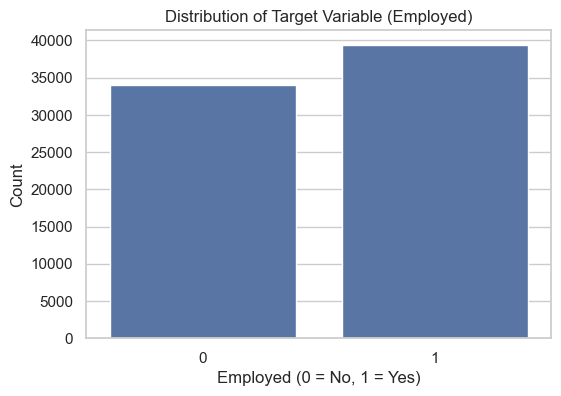

Employed
1    0.536683
0    0.463317
Name: proportion, dtype: float64


In [8]:
# 1. TARGET DISTRIBUTION
plt.figure(figsize=(6,4))
sns.countplot(x=df['Employed'])
plt.title("Distribution of Target Variable (Employed)")
plt.xlabel("Employed (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


# Print numeric balance
print(df['Employed'].value_counts(normalize=True))

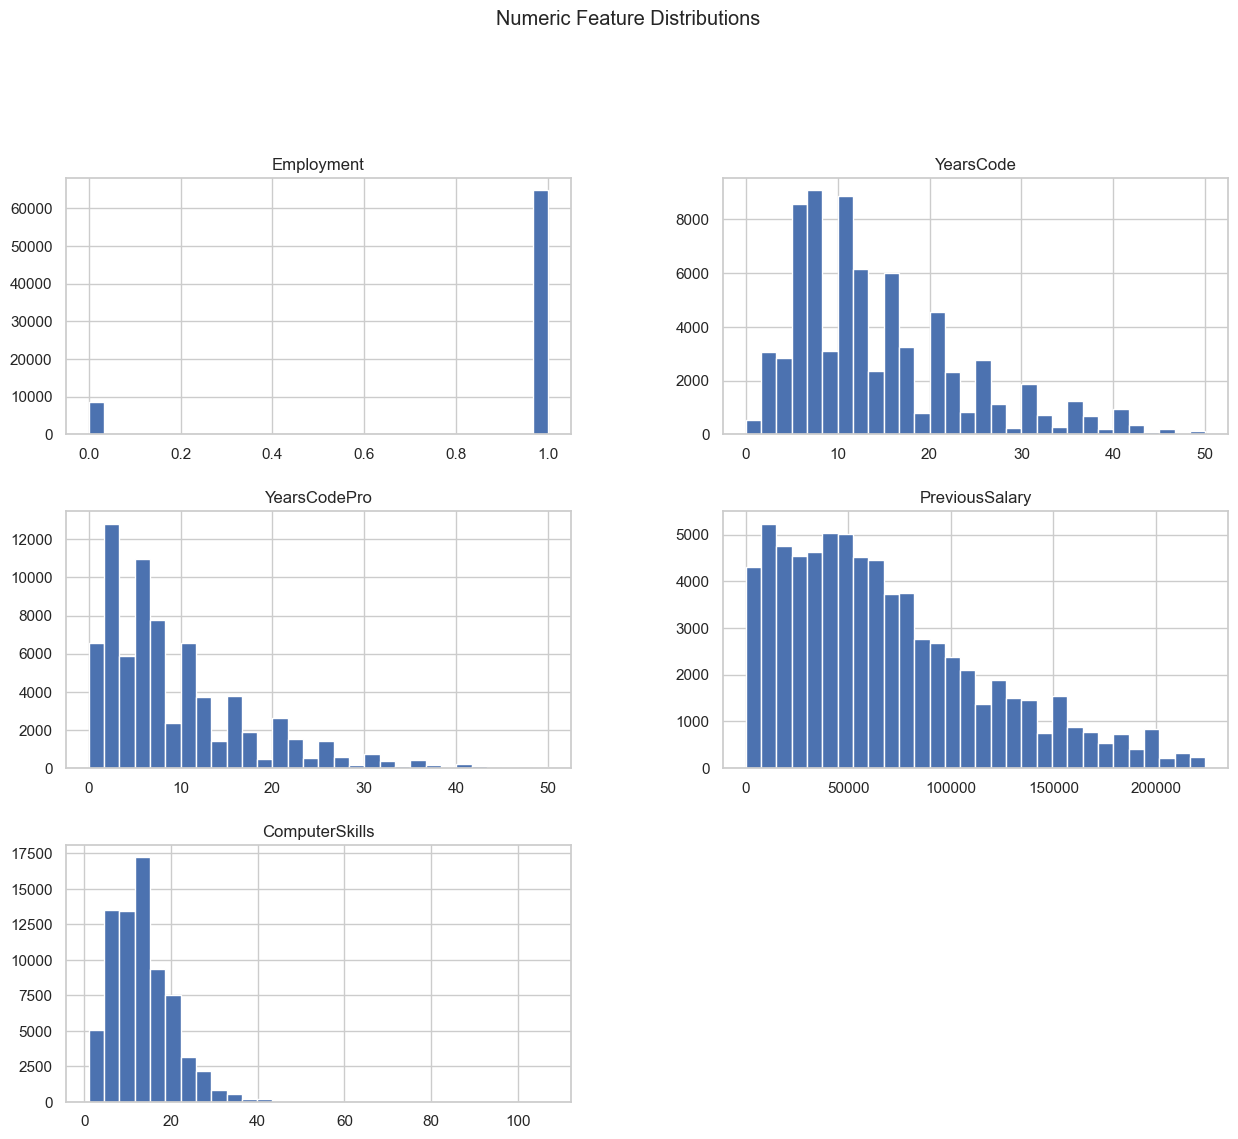

In [9]:
# 3. NUMERIC FEATURE DISTRIBUTIONS

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.drop('Employed')

df[numeric_cols].hist(figsize=(15,12), bins=30)
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.show()

In [10]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Employed','Employment'])

iqr_summary = []

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    pct_outliers = n_outliers / len(df) * 100

    iqr_summary.append({
        "feature": col,
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "lower_fence": lower,
        "upper_fence": upper,
        "#outliers": n_outliers,
        "%outliers": pct_outliers
    })

iqr_df = pd.DataFrame(iqr_summary).sort_values("%outliers", ascending=False)
display(iqr_df)

,feature,Q1,Q3,IQR,lower_fence,upper_fence,#outliers,%outliers
1,YearsCodePro,3.0,12.0,9.0,-10.5,25.5,3349,4.562732
0,YearsCode,7.0,20.0,13.0,-12.5,39.5,1809,2.464611
3,ComputerSkills,8.0,17.0,9.0,-5.5,30.5,1633,2.224826
2,PreviousSalary,28860.0,95979.0,67119.0,-71818.5,196657.5,1479,2.015014


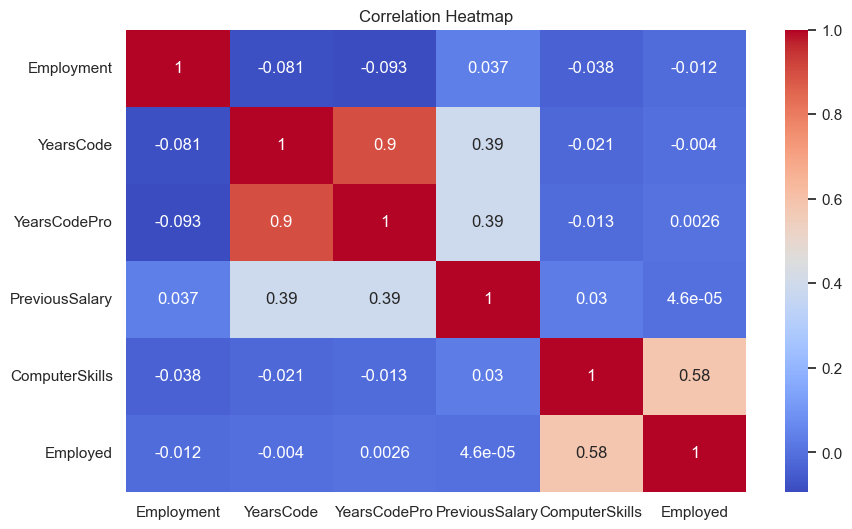

In [11]:
numerical_cols = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

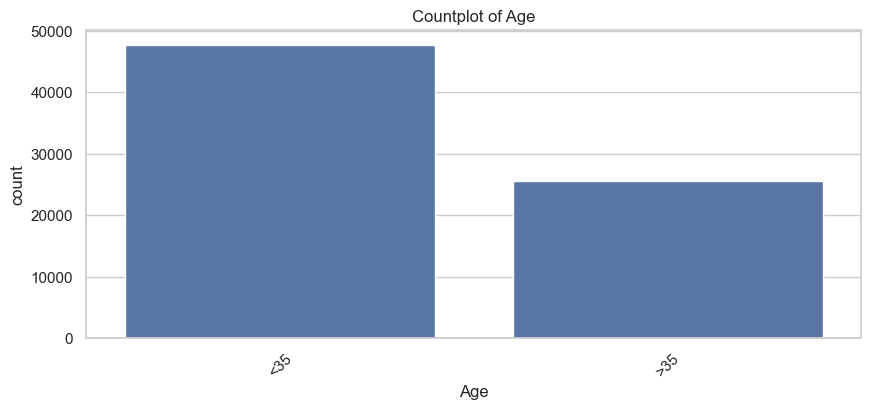

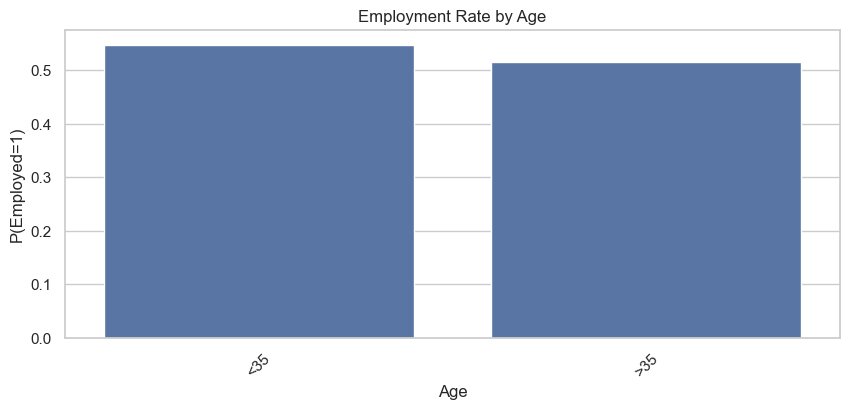

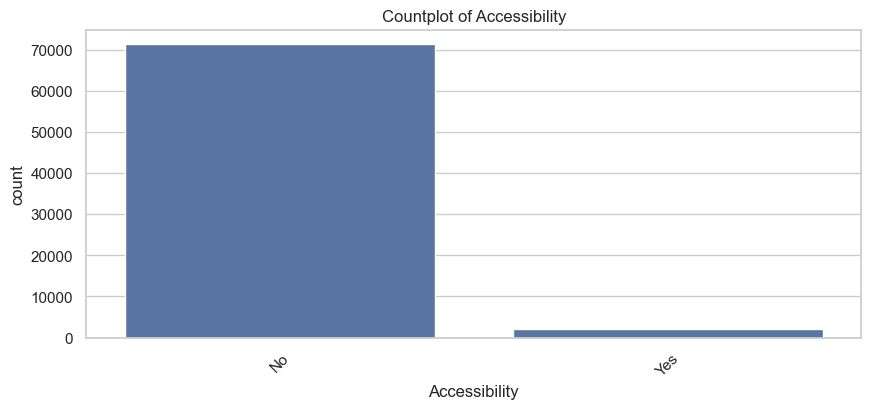

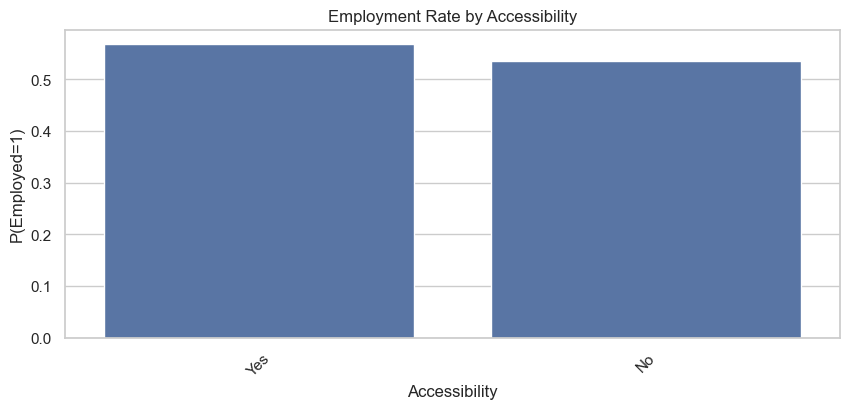

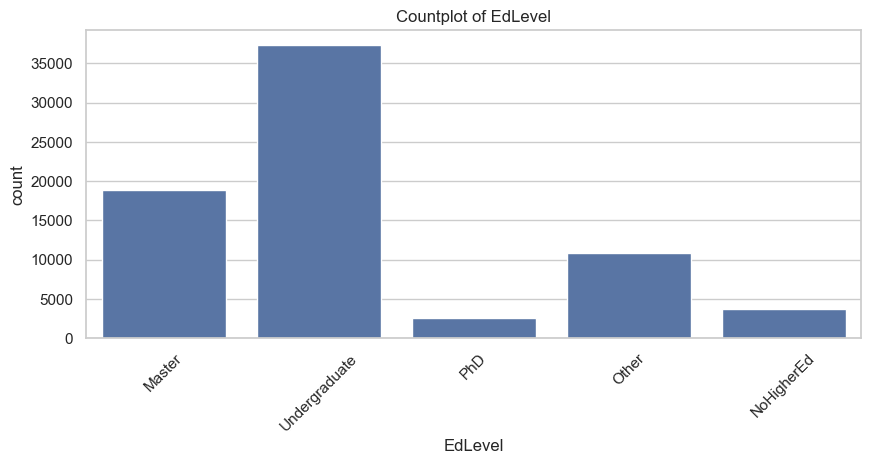

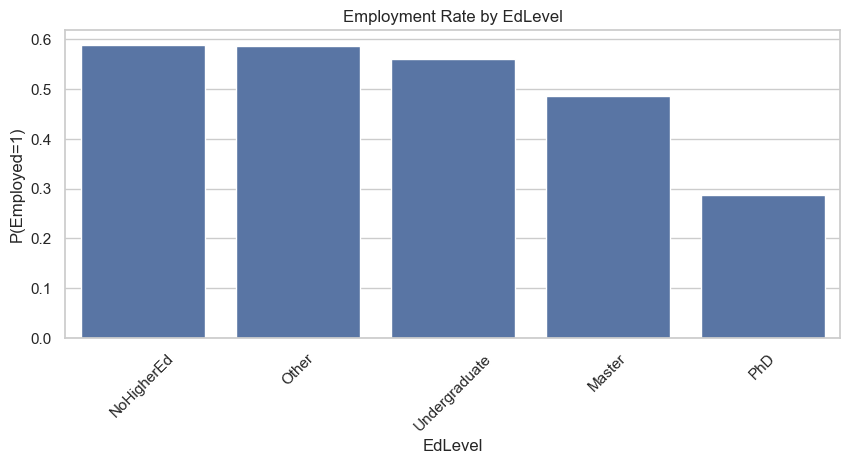

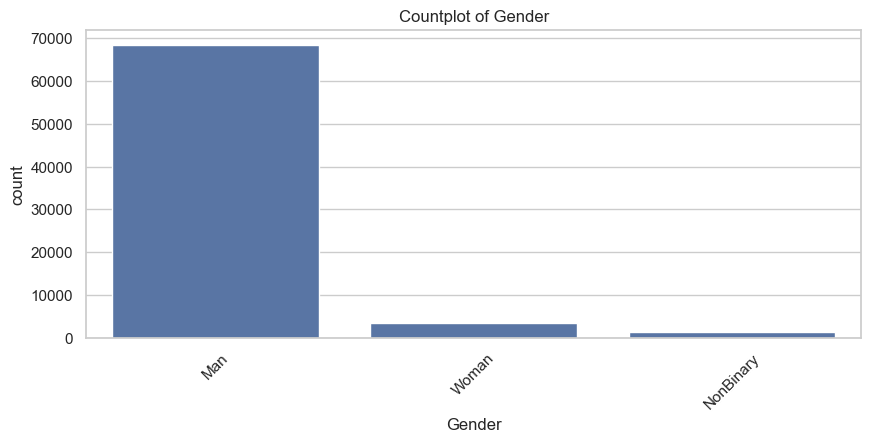

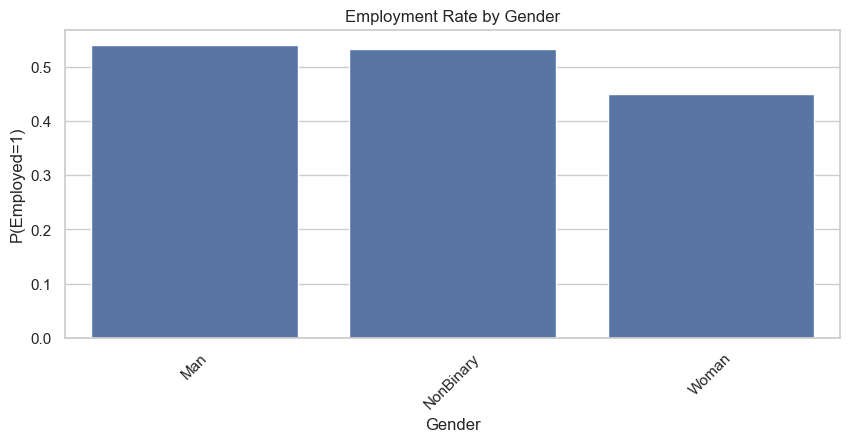

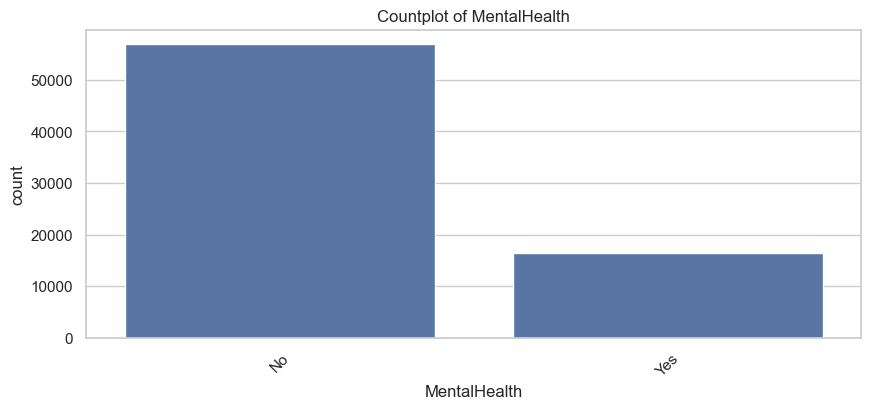

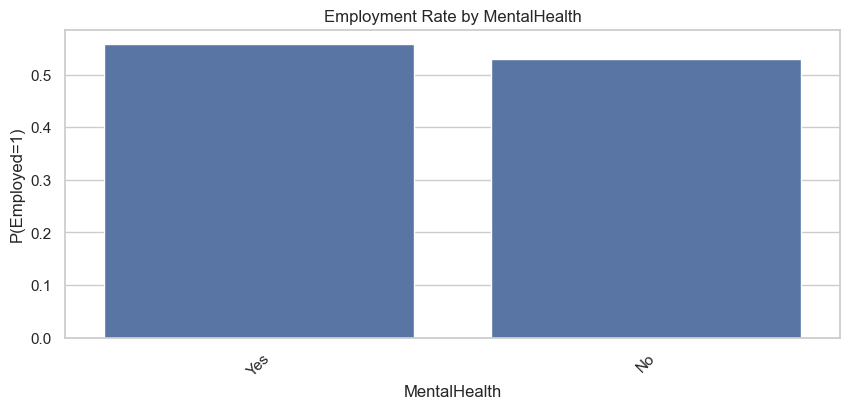

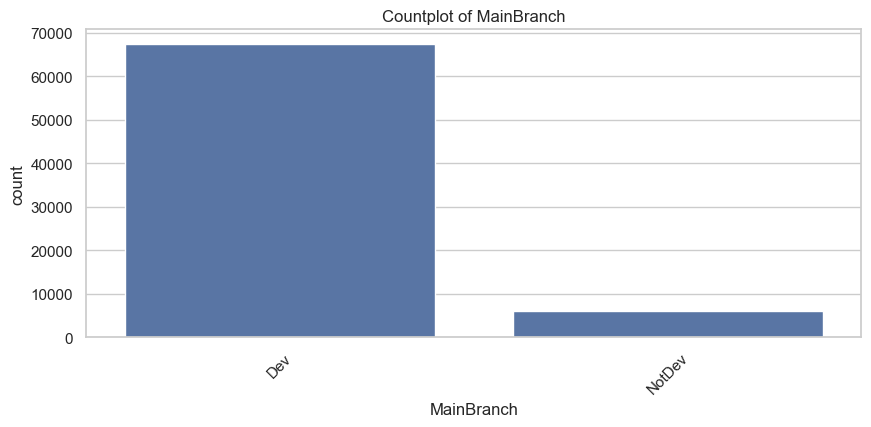

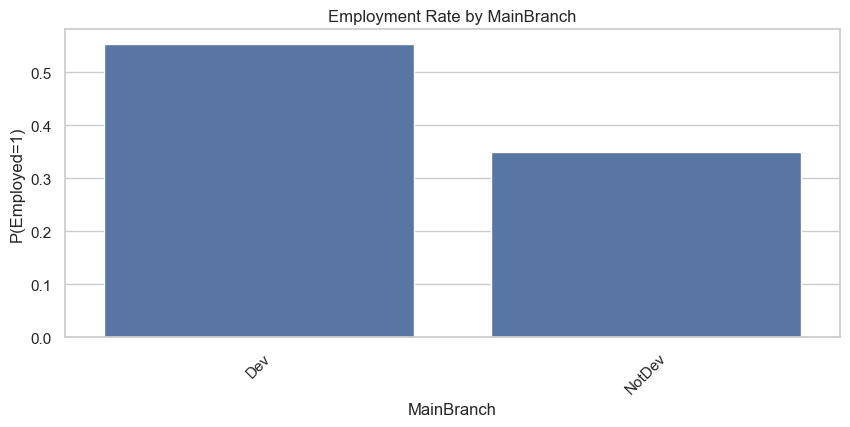

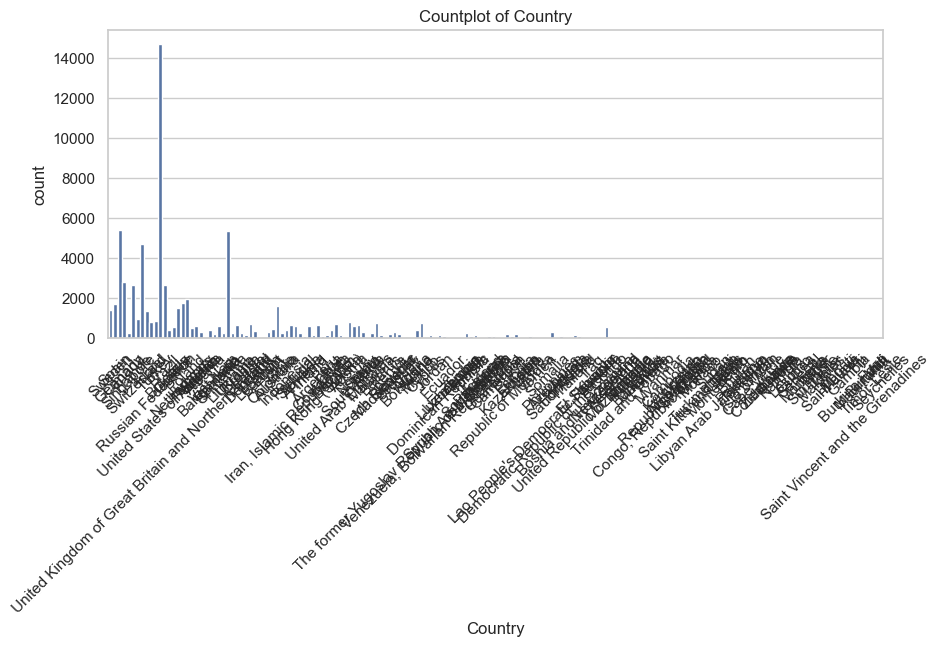

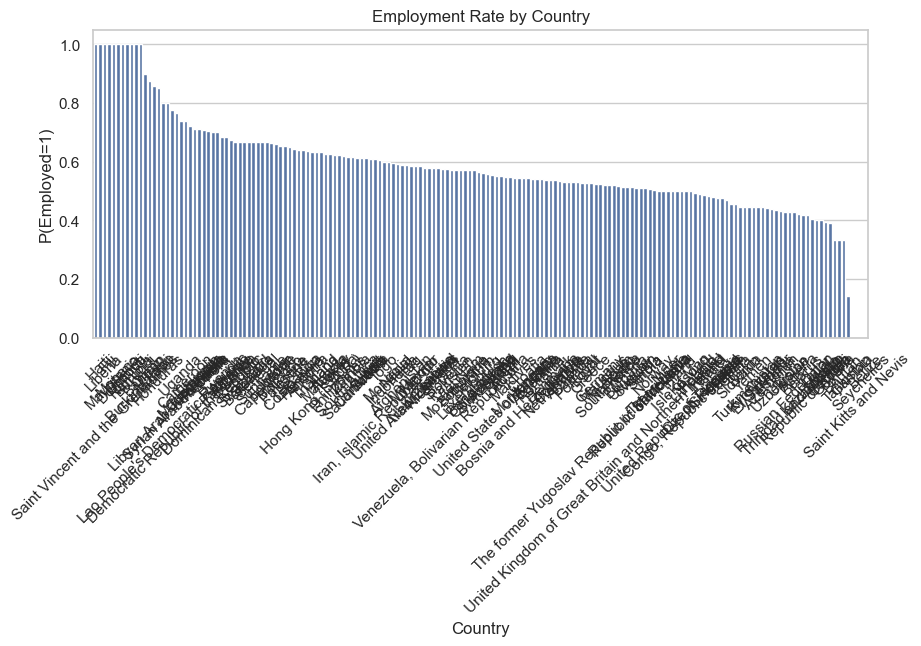

In [12]:
# 5. CATEGORICAL FEATURE ANALYSIS

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.drop('HaveWorkedWith')

for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45)
    plt.show()

    # Target percentage per category
    plt.figure(figsize=(10,4))
    target_rate = df.groupby(col)['Employed'].mean().sort_values(ascending=False)
    sns.barplot(x=target_rate.index, y=target_rate.values)
    plt.xticks(rotation=45)
    plt.ylabel("P(Employed=1)")
    plt.title(f"Employment Rate by {col}")
    plt.show()

In [13]:
# 6. TEXT COLUMN EDA ("HaveWorkedWith")
text_col = "HaveWorkedWith"

# Generating word frequency
vectorizer = CountVectorizer(stop_words="english")
word_matrix = vectorizer.fit_transform(df[text_col].astype(str))
word_counts = np.asarray(word_matrix.sum(axis=0)).ravel()
vocab = np.array(vectorizer.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)

print("Top 20 most common tools/skills:")
display(freq_df.head(20))

Top 20 most common tools/skills:


,word,count
58,js,73460
104,sql,58466
56,javascript,49347
28,docker,40224
20,css,40207
52,html,40207
69,microsoft,38068
45,git,35911
6,aws,31590
91,python,31159


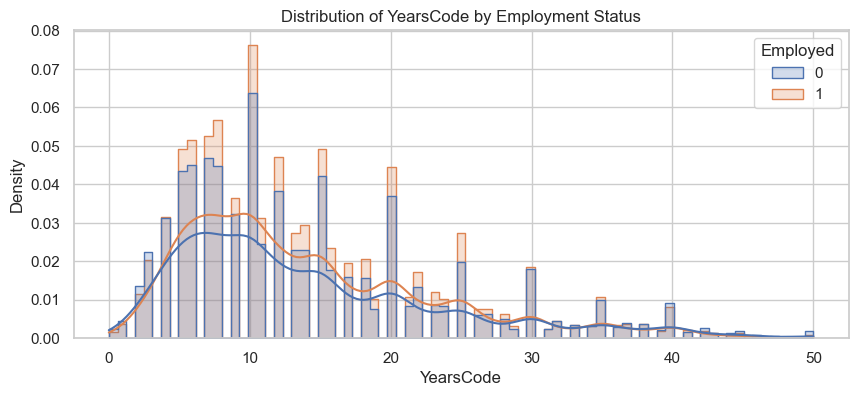

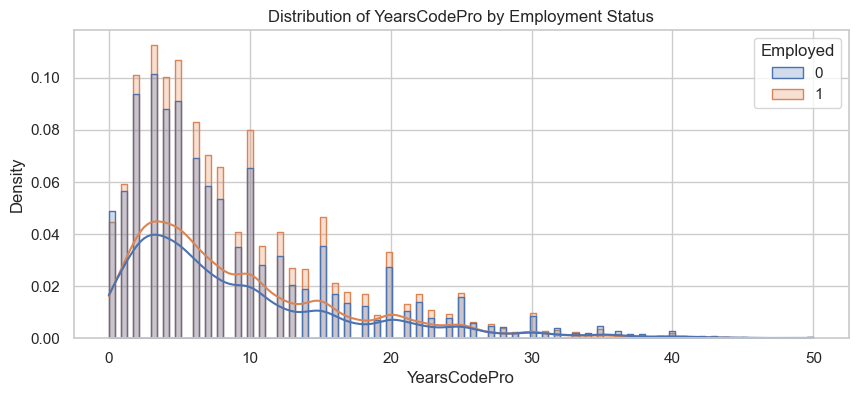

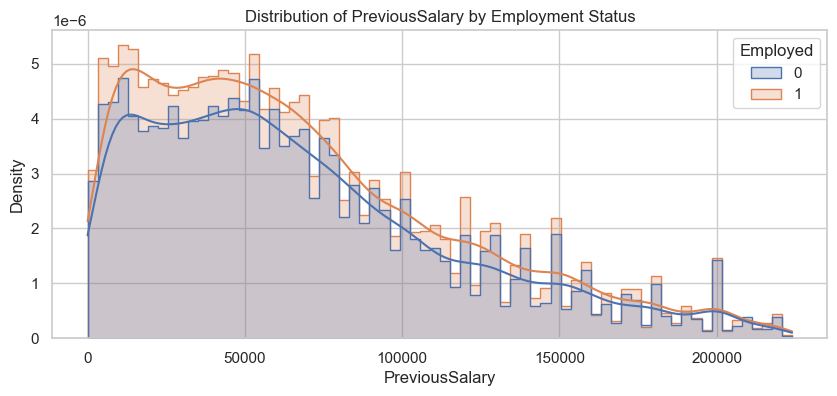

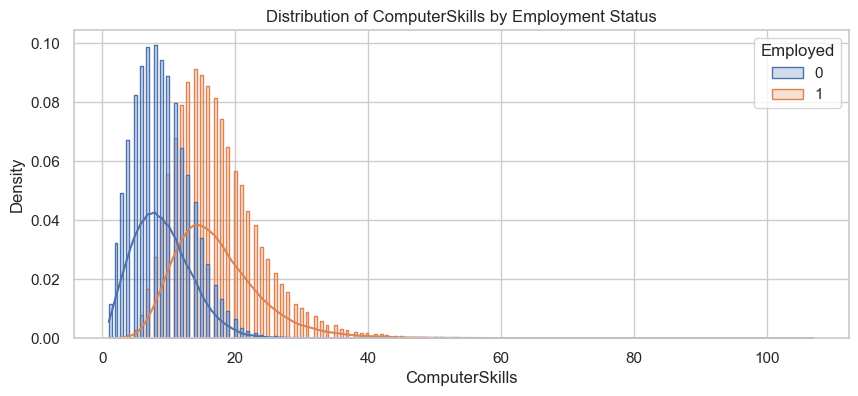

In [14]:
# 7. DISTRIBUTION OF NUMERIC FEATURES BY TARGET

for col in numeric_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(data=df, x=col, hue='Employed', kde=True, element="step", stat="density")
    plt.title(f"Distribution of {col} by Employment Status")
    plt.show()

In [15]:
columns_to_drop = ['YearsCode', 'Age','MentalHealth','Accessibility','Gender'] # removed based on correlation and observation
df = df.drop(columns=columns_to_drop, axis =1)

In [16]:
# 1. Preparing data & 60/20/20 splits

target_col = "Employed"

X = df.drop(columns=[target_col])
y = df[target_col].astype(int) 

# 60% train, 40% temp (valid+test), stratified
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# 20% valid, 20% test from the temp set, stratified
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test :", X_test.shape, y_test.shape)

Shapes:
Train: (44039, 8) (44039,)
Valid: (14680, 8) (14680,)
Test : (14680, 8) (14680,)


In [20]:
from fastapi import FastAPI
import joblib

app = FastAPI(title="HR Resume Screening AI")

model = joblib.load("model.pkl")

@app.post("/predict")
def predict(data: dict):
    prediction = model.predict_proba([list(data.values())])
    return {
        "employability_score": round(prediction[0][1] * 100, 2)
    }

FileNotFoundError: [Errno 2] No such file or directory: 'model.pkl'

In [19]:
pip install fastapi


  Using cached fastapi-0.128.0-py3-none-any.whl.metadata (30 kB)
  Using cached starlette-0.50.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached annotated_doc-0.0.4-py3-none-any.whl.metadata (6.6 kB)
Using cached fastapi-0.128.0-py3-none-any.whl (103 kB)
Using cached annotated_doc-0.0.4-py3-none-any.whl (5.3 kB)
Using cached starlette-0.50.0-py3-none-any.whl (74 kB)
